# VERSION DE DESARROLLO: Niveles de agua del Lago Cocibolca basado en altimetria satelital

- 4/24. Ya estan actualizados los datos de G-REALM
- 3/22 (todavia no se actualizan los datos de G-REALM), 7, 2/13,7, 1/25,23,18/2021

**TO DO:**
- Include `lakepy` examples for both metadata and data
- Print out start and end datetimes
- Extract nivel min & max date per year. Use groupby to extract the nivel and datetime values
- Include some WMS map examples of the Global Surface Water (GSW) product, and links and pointers to the GSW explorer application
- Include HydroLAKES? https://www.hydrosheds.org/pages/hydrolakes (I've downloaded the global shape file)
- DONE. Instalar `lakepy` en el ambiente, y usarlo en este cuaderno


**Apuntes:**
- G-REALM, 
    - [IPAD pagina web, Lago Cocibolca](https://ipad.fas.usda.gov/cropexplorer/global_reservoir/gr_regional_chart.aspx?regionid=ca&reservoir_name=Nicaragua)
    - [IPAD archivo KML con puntos del "track" del sensor altimetrico](https://ipad.fas.usda.gov/rssiws/ggeoxml/351_Nicaragua.kml)
    - Dos tipos de datos:
      - Tipo 1: Status products with datum based on a multi-year mean. Pagina de G-REALM para el Lago Nicaragua esta [aqui](https://ipad.fas.usda.gov/cropexplorer/global_reservoir/gr_regional_chart_jason1.aspx?regionid=ca&reservoir_name=Nicaragua). Ejemplo de archivo de datos: `lake0351.10d.1.txt`
      - Tipo 2: Near Real Time products with datum based on a single satellite overpass (1 day). Pagina de G-REALM para el Lago Nicaragua esta [aqui](https://ipad.fas.usda.gov/cropexplorer/global_reservoir/gr_regional_chart.aspx?regionid=ca&reservoir_name=Nicaragua). Ejemplo de archivo de datos: `lake0351.10d.2.txt`
    - Por cado tipo, datos "smooth" tambien existen: `lake0351.10d.1.smooth.txt` y `lake0351.10d.2.smooth.txt`
- [https://appliedsciences.nasa.gov/join-mission/training/english/mapping-and-monitoring-lakes-and-reservoirs-satellite-observations](https://appliedsciences.nasa.gov/join-mission/training/english/mapping-and-monitoring-lakes-and-reservoirs-satellite-observations) 
- [https://appliedsciences.nasa.gov/our-impact/news/africa-flores-breakthrough-scientist](https://appliedsciences.nasa.gov/our-impact/news/africa-flores-breakthrough-scientist)
- https://www.google.com/search?q=altimetria+satelite+radar
- https://www.aviso.altimetry.fr/es/casero.html
- https://en.wikipedia.org/wiki/Sentinel-6_Michael_Freilich
- *From Charon Birkett*
  - 1/25: The USDA G-REALM site is back up and running
  - 1/22: Yes, all product creation has stopped while the system transfers to a new server, we have also been short of staff to post a news bulletin. We hope the service will resume by Feb 1st. There is no issue with the Jason-3 data. In fact the follow-on mission to Jason-3 (called Sentinel-6) was launched successfully in November 2020. Jason-3 will stop monitoring at the end of 2021.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium
%matplotlib inline
import lakepy as lk

import warnings
warnings.simplefilter('ignore') # filter some warning messages

In [2]:
matplotlib.style.use('ggplot')

## Explorar lakepy

Incluyendo accesso a datos del Lago de Managua (Xolotlan)

In [3]:
lago_nica_lk = lk.search(name='%nicaragua%')

   id_No    source  lake_name
0    129  hydroweb  Nicaragua
1   1943    grealm  Nicaragua


In [4]:
lago_nica_lk_grealm = lk.search(id_No=1943)

,id_No,lake_name,source,Type,Country,Continent,Resolution,grealm_database_ID,Satellite Observation Period
0,1943,Nicaragua,grealm,open,Nicaragua,Central America,10.0,351,Sept 1992-present


Reading lake level records from database...


In [5]:
lago_nica_lk_grealm.metadata

,id_No,lake_name,source,Type,Country,Continent,Resolution,grealm_database_ID,Satellite Observation Period
0,1943,Nicaragua,grealm,open,Nicaragua,Central America,10.0,351,Sept 1992-present


In [6]:
lago_nica_lk_grealm.data.tail()

,id_No,date,lake_name,water_level
1006,1943,2020-10-18,Nicaragua,32.43
1007,1943,2020-11-07,Nicaragua,32.64
1008,1943,2020-11-27,Nicaragua,32.93
1009,1943,2020-12-16,Nicaragua,32.85
1010,1943,2020-12-26,Nicaragua,32.76


In [7]:
lago_nica_lk_hw = lk.search(id_No=129)

,id_No,lake_name,source,basin,status,country,end_date,latitude,longitude,identifier,start_date
0,129,Nicaragua,hydroweb,San Juan,operational,Nicaragua,2020-09-28 15:35,11.5,-85.5,L_nicaragua,1992-10-12 11:31


Reading lake level records from database...


In [8]:
lago_nica_lk_hw.data.tail()

,id_No,date,lake_name,water_level
756,129,2021-02-14,Nicaragua,32.13
757,129,2021-02-19,Nicaragua,32.01
758,129,2021-02-24,Nicaragua,32.05
759,129,2021-03-06,Nicaragua,32.06
760,129,2021-03-07,Nicaragua,31.91


**Resen-as**

- En general, le falta "polish" a este paquete
- La columna `date` no ha sido convertida en una de tipo `date` o `datetime`. Es tipo `str`, lo que no es ideal del todo.
- Los datos de G-REALM no incluyen el nivel *relativo*, no incluye los metadatos adicionales (por ej., lat & lon; satelite; etc), y no especifica cual producto esta siendo usado (tipo 1 vs 2, crudos vs lisos)
- En G-REALM, los datos no estan actualizados (terminan en Oct 18)
- En Hydroweb, `end_date` no corresponde a la fecha mas reciente en el dataframe de datos (`lago_nica_lk_hw.data`)
- `lago_nica_lk_hw.plot_mapview()` estaba muy lento, y lo termine cancelando
- Me parece "bloat" incluir `id_No` y `lake_name` en el `data` dataframe
- En vez de siempre imprimir los metadatos, deberia no imprimirlos por default y talvez incluir un argumento `verbose=False`

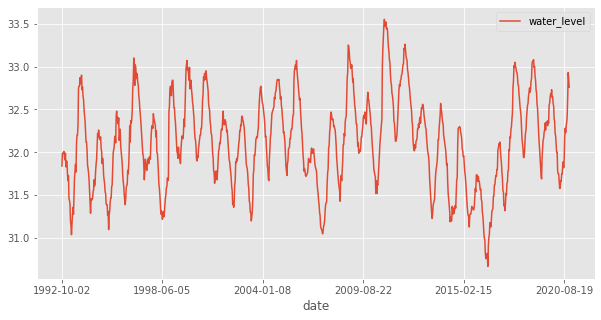

In [9]:
lago_nica_lk_grealm.data.plot(x='date', y='water_level', figsize=(10,5));

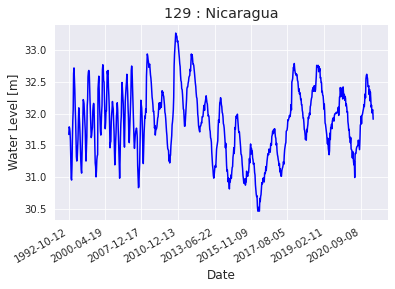

In [10]:
lago_nica_lk_hw.plot_timeseries(how='matplotlib')

In [11]:
lago_managua_lk = lk.search(name='%managua%')

,id_No,lake_name,source,basin,status,country,end_date,latitude,longitude,identifier,start_date
0,109,Managua,hydroweb,San Juan,research,Nicaragua,2015-01-26 20:12,12.35,-86.35,L_managua,2002-10-30 22:47


Reading lake level records from database...


In [12]:
lago_managua_lk_hw = lk.search(id_No=109)

,id_No,lake_name,source,basin,status,country,end_date,latitude,longitude,identifier,start_date
0,109,Managua,hydroweb,San Juan,research,Nicaragua,2015-01-26 20:12,12.35,-86.35,L_managua,2002-10-30 22:47


Reading lake level records from database...


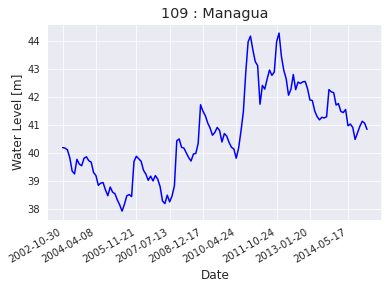

In [13]:
lago_managua_lk_hw.plot_timeseries(how='matplotlib')

## Acceder e ingerir los datos de niveles de agua

In [14]:
datos_tipo = '1'    # '1' o '2'
crudos_o_lisos = '' # '' o '.smooth'

lago_id = '0351'
fname = f"lake{lago_id}.10d.{datos_tipo}{crudos_o_lisos}.txt"
fname

'lake0351.10d.1.txt'

In [15]:
url = f"https://ipad.fas.usda.gov/lakes/images/{fname}"

- Try using `infer_datetime_format` or `date_parser`

**Para usar los datos "crudos":**

```
Column 1: Satellite mission name
Column 2: Satellite repeat cycle
Column 3: Calendar year/month/day of along track observations traversing target
Column 4: Hour of day at mid point of along track pass traversing target
Column 5: Minutes of hour at mid point of along track pass traversing target
Column 6: Target height variation with respect to Jason-2 reference pass mean level (meters, default=999.99)
Column 7: Estimated error of target height variation with respect to reference mean level (meters, default=99.999)
Column 8: Mean along track Ku-band backscatter coefficient (decibels, default=999.99)
Column 9: Wet tropospheric correction applied to range observation (TMR=T/P radiometer, JMR=Jason-1 radiometer, 
    AMR=Jason-2 and Jason-3 radiometer, ERA=ECMWF ERA Interim Reanalysis model, ECM=ECMWF Operational model, 
    MER=MERRA model, MIX=combination, U/A=unavailable, N/A=not applicable)
Column 10: Ionosphere correction applied to range observation (GIM=GPS model, NIC=NIC09 model, DOR=DORIS, 
    IRI=IRI2007 model, BNT=Bent model, MIX=combination, U/A=unavailable, N/A=not applicable)
Column 11: Dry tropospheric correction applied to range observation (ERA=ECMWF ERA Interim Reanalysis model, 
    ECM=ECMWF Operational model, U/A=unavailable, N/A=not applicable)
Column 12: Instrument operating mode 1 (default=9)
Column 13: Instrument operating mode 2 (default=9)
Column 14: Flag for potential frozen surface (ice-on=1, ice-off or unknown=0)
Column 15: Target height variation in EGM2008 datum (meters above mean sea level, default=9999.99)
Column 16: Flag for data source (GDR=0, IGDR=1)
```


**Para usar los datos "lisos" (`smooth`):**

```
Column 1: Calendar year/month/day
Column 2: Hour of day
Column 3: Minute of hour
Column 4: Smoothed target height variation with respect to Jason-2 reference pass level (meters, default=999.99)
Column 5: Smoothed target height variation in EGM2008 datum (meters above mean sea level, default=9999.99)
```

In [16]:
nombres_cols = {
    '': ['satmision', 'satrepetciclo', 
         'fecha', 'hora', 'minuto', 'nivel', 
         'est_error_nivel', 'kuband_scattcoef', 'wettropcorr', 'ionoscorr', 'drytropcorr',
         'instr_opmod1', 'instr_opmod2', 'superfcongelada_flag',
         'nivel_egm2008',
         'fuente_flag'],
    '.smooth': ['fecha', 'hora', 'minuto', 
                'nivel', 
                'nivel_egm2008']
}

skiprows = {
    '1': {'':27, '.smooth':12},
    '2': {'':33, '.smooth':12}
}

In [17]:
df0 = pd.read_csv(
    url, index_col=False, sep='\s+', 
    names=nombres_cols[crudos_o_lisos],
    skiprows=skiprows[datos_tipo][crudos_o_lisos]
)

In [18]:
len(df0)

1116

In [19]:
df0.tail(10)

,satmision,satrepetciclo,fecha,hora,minuto,nivel,est_error_nivel,kuband_scattcoef,wettropcorr,ionoscorr,drytropcorr,instr_opmod1,instr_opmod2,superfcongelada_flag,nivel_egm2008,fuente_flag
1106,JASN3,181,20210115,17,19,0.57,0.042,13.60,AMR,GIM,ECM,2,2,0,32.67,1
1107,JASN3,182,20210125,15,18,0.54,0.042,13.29,AMR,GIM,ECM,2,2,0,32.64,1
1108,JASN3,183,20210204,13,16,0.50,0.042,12.85,AMR,GIM,ECM,2,2,0,32.60,1
1109,JASN3,184,20210214,11,15,0.31,0.042,13.96,AMR,GIM,ECM,2,2,0,32.41,1
1110,JASN3,185,20210224,9,13,0.28,0.042,13.06,AMR,GIM,ECM,2,2,0,32.38,1
1111,JASN3,186,20210306,7,12,0.17,0.042,13.70,AMR,GIM,ECM,2,2,0,32.27,1
1112,JASN3,187,20210316,5,10,0.12,0.042,13.18,AMR,GIM,ECM,2,2,0,32.22,1
1113,JASN3,188,20210326,3,9,0.09,0.042,12.95,AMR,GIM,ECM,2,2,0,32.19,1
1114,JASN3,189,20210405,1,7,-0.02,0.042,12.88,AMR,GIM,ECM,2,2,0,32.08,1
1115,JASN3,190,20210414,23,6,-0.10,0.042,13.75,AMR,GIM,ECM,2,2,0,32.00,1


In [20]:
df0.dtypes

satmision                object
satrepetciclo             int64
fecha                     int64
hora                      int64
minuto                    int64
nivel                   float64
est_error_nivel         float64
kuband_scattcoef        float64
wettropcorr              object
ionoscorr                object
drytropcorr              object
instr_opmod1              int64
instr_opmod2              int64
superfcongelada_flag      int64
nivel_egm2008           float64
fuente_flag               int64
dtype: object

## Pre-procesar y suplementar los datos ingeridos

In [21]:
df = df0[(df0['fecha'] != 99999999) & (df0['nivel'] < 999)].copy()
len(df)

1085

In [22]:
# Time *must* be zero-padded in conversion from integer to string
df.insert(1, 'FechaTiempo', 
          pd.to_datetime(
              df['fecha'].map(str) 
              + df['hora'].map(lambda nbr: "{0:02d}".format(nbr))
              + df['minuto'].map(lambda nbr: "{0:02d}".format(nbr)),
              format='%Y%m%d%H%M')
         )

In [23]:
df.drop(['fecha', 'hora', 'minuto'], axis=1, inplace=True)

In [24]:
df.FechaTiempo.min(), df.FechaTiempo.max()

(Timestamp('1992-10-02 14:54:00'), Timestamp('2021-04-14 23:06:00'))

In [25]:
df.tail(15)

,satmision,FechaTiempo,satrepetciclo,nivel,est_error_nivel,kuband_scattcoef,wettropcorr,ionoscorr,drytropcorr,instr_opmod1,instr_opmod2,superfcongelada_flag,nivel_egm2008,fuente_flag
1101,JASN3,2020-11-27 03:26:00,176,0.82,0.042,13.96,AMR,GIM,ECM,2,2,0,32.92,1
1102,JASN3,2020-12-07 01:25:00,177,0.79,0.042,14.44,AMR,GIM,ECM,2,2,0,32.89,1
1103,JASN3,2020-12-16 23:23:00,178,0.75,0.042,14.61,AMR,GIM,ECM,2,2,0,32.85,1
1104,JASN3,2020-12-26 21:22:00,179,0.67,0.042,13.27,AMR,GIM,ECM,2,2,0,32.77,1
1105,JASN3,2021-01-05 19:21:00,180,0.66,0.042,13.51,AMR,GIM,ECM,2,2,0,32.76,1
1106,JASN3,2021-01-15 17:19:00,181,0.57,0.042,13.60,AMR,GIM,ECM,2,2,0,32.67,1
1107,JASN3,2021-01-25 15:18:00,182,0.54,0.042,13.29,AMR,GIM,ECM,2,2,0,32.64,1
1108,JASN3,2021-02-04 13:16:00,183,0.50,0.042,12.85,AMR,GIM,ECM,2,2,0,32.60,1
1109,JASN3,2021-02-14 11:15:00,184,0.31,0.042,13.96,AMR,GIM,ECM,2,2,0,32.41,1
1110,JASN3,2021-02-24 09:13:00,185,0.28,0.042,13.06,AMR,GIM,ECM,2,2,0,32.38,1


**Hay que averiguar porque los datos terminan en Octubre.**

In [26]:
df['año'] = df.FechaTiempo.dt.year
df['mes'] = df.FechaTiempo.dt.month
df['dia'] = df.FechaTiempo.dt.day
df['dda'] = df.FechaTiempo.dt.dayofyear

## Explorar patrones temporales

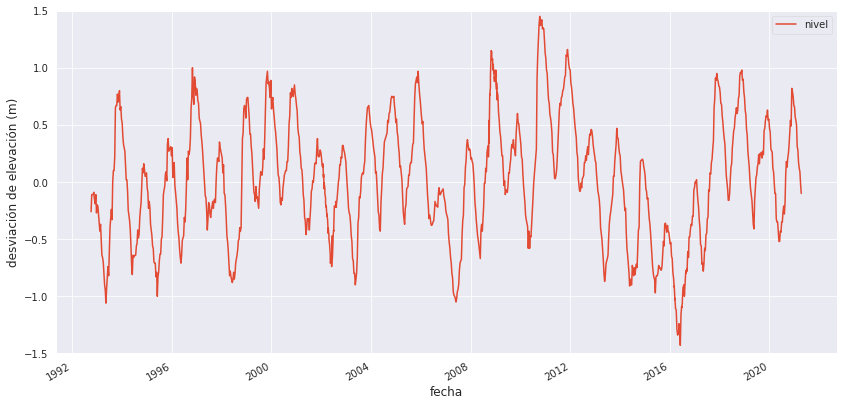

In [27]:
df.plot(x='FechaTiempo', y='nivel', ylim=(-1.5, 1.5), figsize=(14, 7))
plt.ylabel('desviación de elevación (m)')
plt.xlabel('fecha');

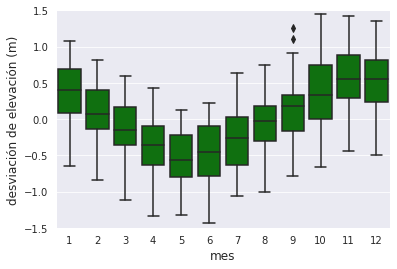

In [28]:
sns.boxplot(data=df, x='mes', y='nivel', color='g');
plt.ylim(-1.5, 1.5)
plt.xlabel('mes')
plt.ylabel('desviación de elevación (m)'); 

In [29]:
# df.plot.scatter(x="dda", y="nivel", c="año");

x-axis date formatting. Probably better to use matplotlib date formatting. See https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

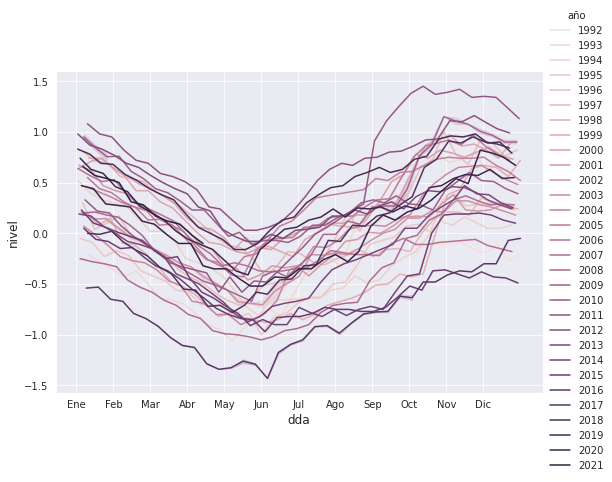

In [30]:
# markers=True, dashes=False: these have no effect
palette = sns.cubehelix_palette(light=.9, n_colors=len(df['año'].unique()))

sns.relplot(data=df, x="dda", y="nivel", hue="año", kind='line', palette=palette,
            height=5, aspect=1.5)
# Change x axis labelling to show months rather than just dda integers
# 0,365 for start of month; 15,380 for middle of month
plt.xticks(np.linspace(0,365,13)[:-1], 
           ('Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic')
          );

Nota: Para estas figuras, hay que eliminar los años incompletos -- el primero y tipicamente el ultimo (a menos que la fecha mas reciente sea mediados de diciembre)

In [31]:
dfg = df.groupby('año')

Una sola figura con el promedio, minimo y maximo anual

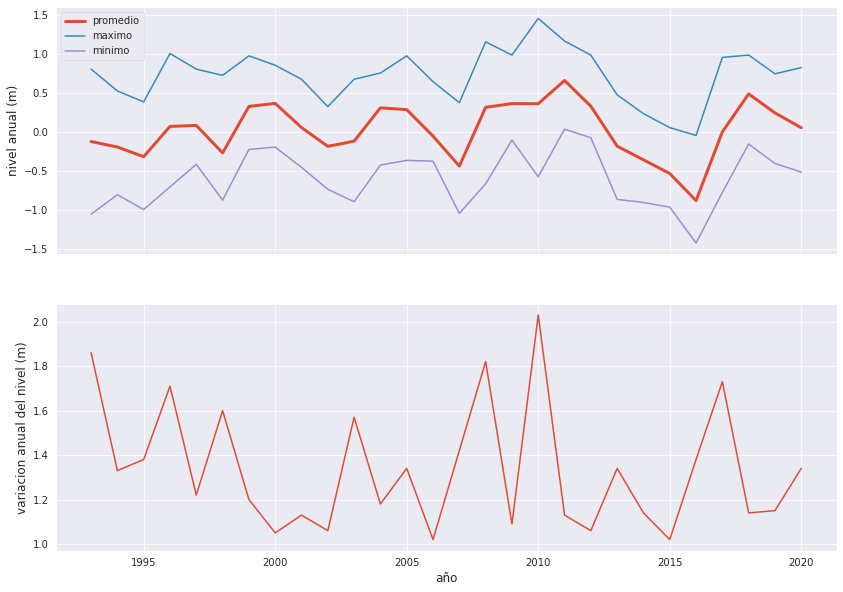

In [32]:
fig, ejes = plt.subplots(nrows=2, figsize=(14,10), sharex=True)

dfg.nivel.mean().iloc[1:-1].plot(ax=ejes[0], label='promedio', linewidth=3)
dfg.nivel.max().iloc[1:-1].plot(ax=ejes[0], label='maximo')
dfg.nivel.min().iloc[1:-1].plot(ax=ejes[0], label='minimo')
ejes[0].set_ylabel('nivel anual (m)')
ejes[0].legend()

dfheightrange = dfg.nivel.max().iloc[1:-1] - dfg.nivel.min().iloc[1:-1]
dfheightrange.plot(ax=ejes[1])
ejes[1].set_ylabel('variacion anual del nivel (m)');

## Leer el paso satelital y visualizar en un mapa

In [33]:
kmlurl = "https://ipad.fas.usda.gov/rssiws/ggeoxml/351_Nicaragua.kml"

In [34]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

See this good reference for reading KMLs and their complexities: https://gis.stackexchange.com/questions/328525/geopandas-read-file-only-reading-first-part-of-kml

In [35]:
gdf = gpd.read_file(kmlurl, driver='KML')

In [36]:
len(gdf)

190

In [37]:
gdf.tail()

,Name,Description,geometry
185,,,POINT (-85.63035 0.00000)
186,,,POINT (-85.62943 0.00000)
187,,,POINT (-85.62851 0.00000)
188,,,POINT (-85.62759 0.00000)
189,Topex/Jason Pass,,"LINESTRING (-85.80074 11.56268, -85.79982 11.5..."


In [38]:
gdf.geometry.type.value_counts()

Point         189
LineString      1
dtype: int64

In [39]:
# usando folium.Figure para controlar el taman-o sin introducir "padding"
fig = folium.Figure(width='60%')
mapa = folium.Map(tiles='StamenTerrain').add_to(fig)

folium.GeoJson(
    gdf[gdf.Name == 'Topex/Jason Pass'].geometry,
    tooltip="Paso satelital Topex/Jason"
).add_to(mapa)

# Set the map extent (bounds) to the extent of the bounding box
mapa.fit_bounds(mapa.get_bounds())

In [40]:
mapa